In [1]:
suppressPackageStartupMessages({
library(gplots)
library(NanoStringNCTools)
library(RColorBrewer)
library(grid)
library(gridExtra)
library(ggalluvial)
library(knitr)
library(ggplot2)
library(dplyr)
library(plyr)
library(openxlsx)
library(limma)
library(DESeq2)
library(lme4)
library(AnnotationDbi)
library(org.Hs.eg.db)
library(clusterProfiler)
library(png)
library(grid)
library(gridExtra)
library(ggforce)
library(tidyverse)
source('geomx_helper_functions.R')
})
cd45_color = '#F8766D'
ck_color = '#00BA38'
cd68_color = '#619CFF'
color_patient_1 <- "#999999"
color_patient_2 <- "#E69F00"
color_patient_3 <- "#56B4E9"
color_patient_4 <- "#009E73"
color_patient_5 <- "#F0E442"
color_patient_6 <- "#0072B2"
color_patient_7 <- "#D55E00"
metastasis_col <- "#F8766D"
primitive_col<- "#00BFC4"
tumoral_col <- "#A0D5C7" 
stromal_col <- "#56B4E9"
no_cd68_col <- "#E69F00"
adjacent_col <- "#999999"
cutaneous_col <- "#F8766D"
liver_col <- "#B79F00"
node_col <- "#00BA38"
peritoneum_col <- "#00BFC4"
gastric_col <- "#619CFF"
intra_col <- "#F8A40D"
extra_col <- "#A88E7C"
low <- "#83AF9B"
mid <- "#F9CDAD"
high <- "#FE4365"
my_colors <- c(
    "CK"= ck_color,
    "CD68" = cd68_color, 
    "CD45" = cd45_color,
    "pancreas patient 1" = color_patient_1,
    "pancreas patient 2" = color_patient_2,
    "pancreas patient 3" = color_patient_3,
    "pancreas patient 4" = color_patient_4,
    "pancreas patient 5" = color_patient_5,
    "pancreas patient 6" = color_patient_6,
    "pancreas patient 7" = color_patient_7,
    'metastasis'= metastasis_col,
    'primitive'= primitive_col,
    'tumoral'= tumoral_col,
    'stromal'= stromal_col,
    'no_cd68'= no_cd68_col,
    'adjacent'= adjacent_col,
    'cutaneous' =cutaneous_col,
    'liver' =liver_col,
    'node' = node_col,
    'peritoneum' = peritoneum_col,
    'peritoneum/gastric wall' = gastric_col,
    'intra-tumor' = intra_col,
    'extra-tumor' = extra_col,
    'low' = low,
    'mid' = mid,
    'high' = high
)

Warning message:
“package ‘ggplot2’ was built under R version 4.4.3”
Warning message:
“package ‘knitr’ was built under R version 4.4.3”
Warning message:
“package ‘DESeq2’ was built under R version 4.4.3”
Warning message:
“package ‘lme4’ was built under R version 4.4.3”
Warning message:
“package ‘Matrix’ was built under R version 4.4.3”
Warning message:
“package ‘tibble’ was built under R version 4.4.3”
Warning message:
“package ‘pheatmap’ was built under R version 4.4.3”


In [27]:
add_score_cat<-function(df,segment){
    score <- paste0(segment,'_score')
    score_cat <- paste0(score,'_cat')
    df[[score_cat]] <- NA
    high_scores <- head(sort(df[[score]],decreasing = T), n = 10)
    low_scores <- head(sort(df[[score]][!is.na(df[[score]])],decreasing = F),n = 10)
    for (i in 1:nrow(df)) {
            if (df[[score]][i] %in% high_scores) {
                    df[[score_cat]][i] <- "high"
            } else if (df[[score]][i] %in% low_scores) {
                    df[[score_cat]][i] <- "low"
            } else if (is.na(df[[score]][i])){
                    df[[score_cat]][i] <- NA
            } else {
                    df[[score_cat]][i] <- "mid"
            }
    }
    return(df)
}

load("target_demoData.RData")

annotations <- pData(target_demoData)

annotations <- add_score_cat(annotations,'cd68')
annotations <- add_score_cat(annotations,'cd45')
annotations <- add_score_cat(annotations,'ck')
pData(target_demoData) <- annotations
folder_slide_dict<- list(
    "11H01838.06 PRIMITIVE 07-07-2022"="11H01838.06 PRIMITIVE 07-07-2022",
    "12H10481.07 PANCREAS METASTASE 13.09.22"="12H10481.07 PANCREAS METASTASE 13.09.22",
    "14H08500-20 PANCREAS _4 27-09-22"="14H08500-20 PANCREAS #4 27-09-22",
    "14H08500-27 primitive 11-10-22"="14H08500-27 primitive 11-10-22",
    "14H09773-15 Pancreas _5 5-10-22"="14H09773-15 Pancreas #5 5-10-22",
    "15H01447-01 PANCREAS _4 meta cutanee 27-09-22"="15H01447-01 PANCREAS #4 meta cutanee 27-09-22",
    "15H02500-A meta _5 5-10-22"="15H02500-A meta #5  5-10-22",
    "15H03125-18 Pancreas TSIP 15-09-22"="15H03125-18 Pancreas TSIP 15-09-22",
    "15H03125-41 Meta GG 15-09-22"="15H03125-41 Meta GG  15-09-22",
    "18H03710-14 meta Colon _3 20-10-22"="19H12583-14 (TSIP) 20-09-22",
    "20E00932 meta Pancreas _7bis 20-10-22"="20E00932 meta Pancreas #7bis 20-10-22",
    "21H02991-03 Meta colique (Pancreas _8) 20-09-22"="21H02991-03 Meta colique (Pancreas #8) 20-09-22",
    "21H02991-13 PANCREAS 15-09-22"="21H02991-13 PANCREAS  15-09-22",
    "21H06915-18 Pancreas Primitive _9"="21H06915-18 Pancreas Primitive #9",
    "21H06915-D Pancreas Meta GG _9"="21H06915-D Pancreas Meta GG #9",
    "22D00066 Pancreas _7bis 20-10-22"="22D00066 Pancreas #7bis 20-10-22"
)

####### add nuclei and cd68 type #######
pData(target_demoData)$folder <- names(folder_slide_dict)[match(pData(target_demoData)$`slide name`, unlist(folder_slide_dict))]

prim_ind <- pData(target_demoData)$primitive_metastasis == "primitive"
prim_subset <- target_demoData[, prim_ind]
meta_ind <- pData(target_demoData)$primitive_metastasis == "metastasis"
meta_subset <- target_demoData[, meta_ind]
results = 'results'

# ploting functions

In [22]:
plot_rois <- function(dataset,path,rows=5,cols=8){
    print(pData(dataset)$roi)
    annotations_sorted <- subset(pData(dataset)[order(pData(dataset)$ck_score),],!is.na(cd45_score) & !is.na(ck_score))
    my_list <- paste(unique(annotations_sorted[,c('folder','roi')])$folder, unique(annotations_sorted[,c('folder','roi')])$roi,sep='_')
    pngs <- lapply(my_list, function(x) {paste0(path, x, ".png")})
    
    raster_list <- lapply(pngs, function(x) {
      rasterGrob(readPNG(x), interpolate = TRUE)
    })
    grid.arrange(grobs = raster_list, nrow = rows, ncol = cols)
    
}

stacked_barplot <- function(dataset,columns){
    pData(dataset)$rowname <- rownames(pData(dataset))
    cols <-c('rowname',columns)
    df_long <- pData(dataset)[cols] %>%
      pivot_longer(cols = -rowname, names_to = "Variable", values_to = "Value")

    df_long <- df_long %>%
     group_by(Variable, Value) %>%
     summarise(count = n())

    # Plot with labels
    p <- ggplot(df_long, aes(x = Variable, y = count, fill = Value)) +
     geom_bar(stat = "identity", position = "stack") +
     geom_text(aes(label = Value), position = position_stack(vjust = 0.5),cex = 3) +
     theme_minimal()+ theme(legend.position = "none",axis.text.x = element_text(size = 12, angle = 30, vjust = 0.7, hjust = 0.5)) +
     scale_fill_manual(values = my_colors)
    return(p)
}
sankey_plot <- function(df,columns) {
    data <- table(df[,columns])
    data <- reshape2::melt(data)
    data <- gather_set_data(data, 1:length(columns))
    p <- ggplot(data, aes(x, id = id, split = y, value = value)) +
      geom_parallel_sets(aes(fill = segment), alpha = 0.3, axis.width = 0.1) +
      scale_fill_manual(values = c("CK" = ck_color, "CD45" = cd45_color,'CD68'=cd68_color)) +
      geom_parallel_sets_axes(axis.width = 0.1) +
      geom_parallel_sets_labels(colour = 'black', angle = 0, nudge_x = 0.1, hjust = 0.) +
          coord_cartesian(xlim = c(1, 3.7),clip = 'off') +
      theme_classic()+
      theme(axis.ticks.y = element_blank(),
           axis.line = element_blank(),
           axis.text.y = element_blank()) + 
            scale_y_continuous(expand = expansion(0)) +
        scale_x_discrete(expand = expansion(0)) +
        labs(x = "", y = "") 
    
    return(p)
}

######## plot proportions per cd68 type #########
plot_proportions <- function(annotations,column,score_cat) {
    combinations <- crossing(annotations$segment,annotations[[score_cat]])
    combinations <- as.data.frame(combinations)
    
    combinations <- combinations[complete.cases(combinations),]
    names(combinations) <- c('segment','score_cat')
    sums <- c()
    for(i in 1:nrow(combinations)) {
        segment <- combinations[i,'segment']
        s <- combinations[i,'score_cat']
        sub <- annotations[annotations$segment == segment & annotations[[score_cat]] == s,][[column]]
        sum_ <- sum(sub[!is.na(sub)])
        sums <- c(sums,sum_)
    }
    names(combinations) <- c('segment','score_cat')
    df <- data.frame(segment = combinations$segment,score_cat = combinations$score_cat,column = sums)
    df <- df[df$column != 0,]
    df$proportions <- NA
    for (i in unique(df$score_cat)){
        total <- sum(df[df$score_cat ==i,]$column)
        df[df$score_cat ==i,]$proportions <- df[df$score_cat ==i,]$column / total
    }
    #df <- df[!df$cd68_type %in% c('adjacent','no_cd68'),] # Remove adjacent and no_cd68 rois
    rownames(df) <- seq_len(nrow(df))
    custom_order <- c('high','mid','low')
    custom_colors <- c("#F8766D", "#619CFF","#00BA38") 
    names(custom_colors) <- levels(df$segment)
    df$segment <- as.factor(df$segment)
    p1 <- ggplot(data = df, aes(x = factor(score_cat, levels=custom_order),y=column, alluvium = segment, stratum=segment,fill = segment)) +
    geom_alluvium() + geom_stratum() +
    scale_fill_manual(values = custom_colors) +
    theme(panel.background = element_blank(),
          axis.title.x = element_blank(),
          axis.ticks.y = element_blank(),
          axis.ticks.x = element_blank())+
    labs(title = paste(column, "numbers"))
    p2 <- ggplot(data = df, aes(x = factor(score_cat, levels=custom_order),y=proportions, alluvium = segment, stratum=segment,fill = segment)) +
    geom_alluvium() + geom_stratum() +
    scale_fill_manual(values = custom_colors) +
    theme(panel.background = element_blank(),
          axis.title.x = element_blank(),
          axis.ticks.y = element_blank(),
          axis.ticks.x = element_blank())+
    labs(title = paste(column, "proportions"))
    return(list(plot1 = p1, plot2 = p2))
}

plot_proportions_categorical <- function(annotations,feature,score_cat){
    combinations <- crossing(annotations[[feature]],annotations[[score_cat]])
    combinations <- as.data.frame(combinations)
    combinations <- combinations[complete.cases(combinations),]
    names(combinations) <- c('feature',score_cat)
    sums <- c()
    for(i in 1:nrow(combinations)) {
        f <- combinations[i,'feature']
        s <- combinations[i,score_cat]
        sub <- annotations[annotations[[feature]] == f  & annotations[[score_cat]] == s,][[feature]]
        sum_ <- length(sub)
        sums <- c(sums,sum_)
    }
    df <- data.frame(feature = combinations$feature,score_cat = combinations[[score_cat]],column = sums)
    df <- df[df$column != 0,]
    df$proportions <- NA
    
    for (i in unique(df$score_cat)){
        total <- sum(df[df$score_cat ==i,]$column)
        df[df$score_cat ==i,]$proportions <- df[df$score_cat ==i,]$column / total
    }
    
    rownames(df) <- seq_len(nrow(df))
    custom_order <- c('high','mid','low')
    custom_colors <-  c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
    names(custom_colors) <- levels(df[[feature]])
    df$feature <- as.factor(df$feature)
    
    p1 <- ggplot(data = df, aes(x = factor(score_cat, levels=custom_order),y=column, alluvium = feature, stratum=feature,fill = feature)) +
    geom_alluvium() + geom_stratum() +
    scale_fill_manual(values = custom_colors) +
    theme(panel.background = element_blank(),
          axis.title.x = element_blank(),
          axis.ticks.y = element_blank(),
          axis.ticks.x = element_blank())+
    labs(title = paste("Absolute Numbers: ",feature))
    p2 <- ggplot(data = df, aes(x = factor(score_cat, levels=custom_order),y=proportions, alluvium = feature, stratum=feature,fill = feature)) +
    geom_alluvium() + geom_stratum() +
    scale_fill_manual(values = custom_colors) +
    theme(panel.background = element_blank(),
          axis.title.x = element_blank(),
          axis.ticks.y = element_blank(),
          axis.ticks.x = element_blank())+
    labs(title = paste("Proportions: ",feature))
    return(list(plot1 = p1, plot2 = p2))
}

# Stacked Barplots

`summarise()` has grouped output by 'Variable'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Variable'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Variable'. You can override using the `.groups` argument.
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_text()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_text()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_text()`).”


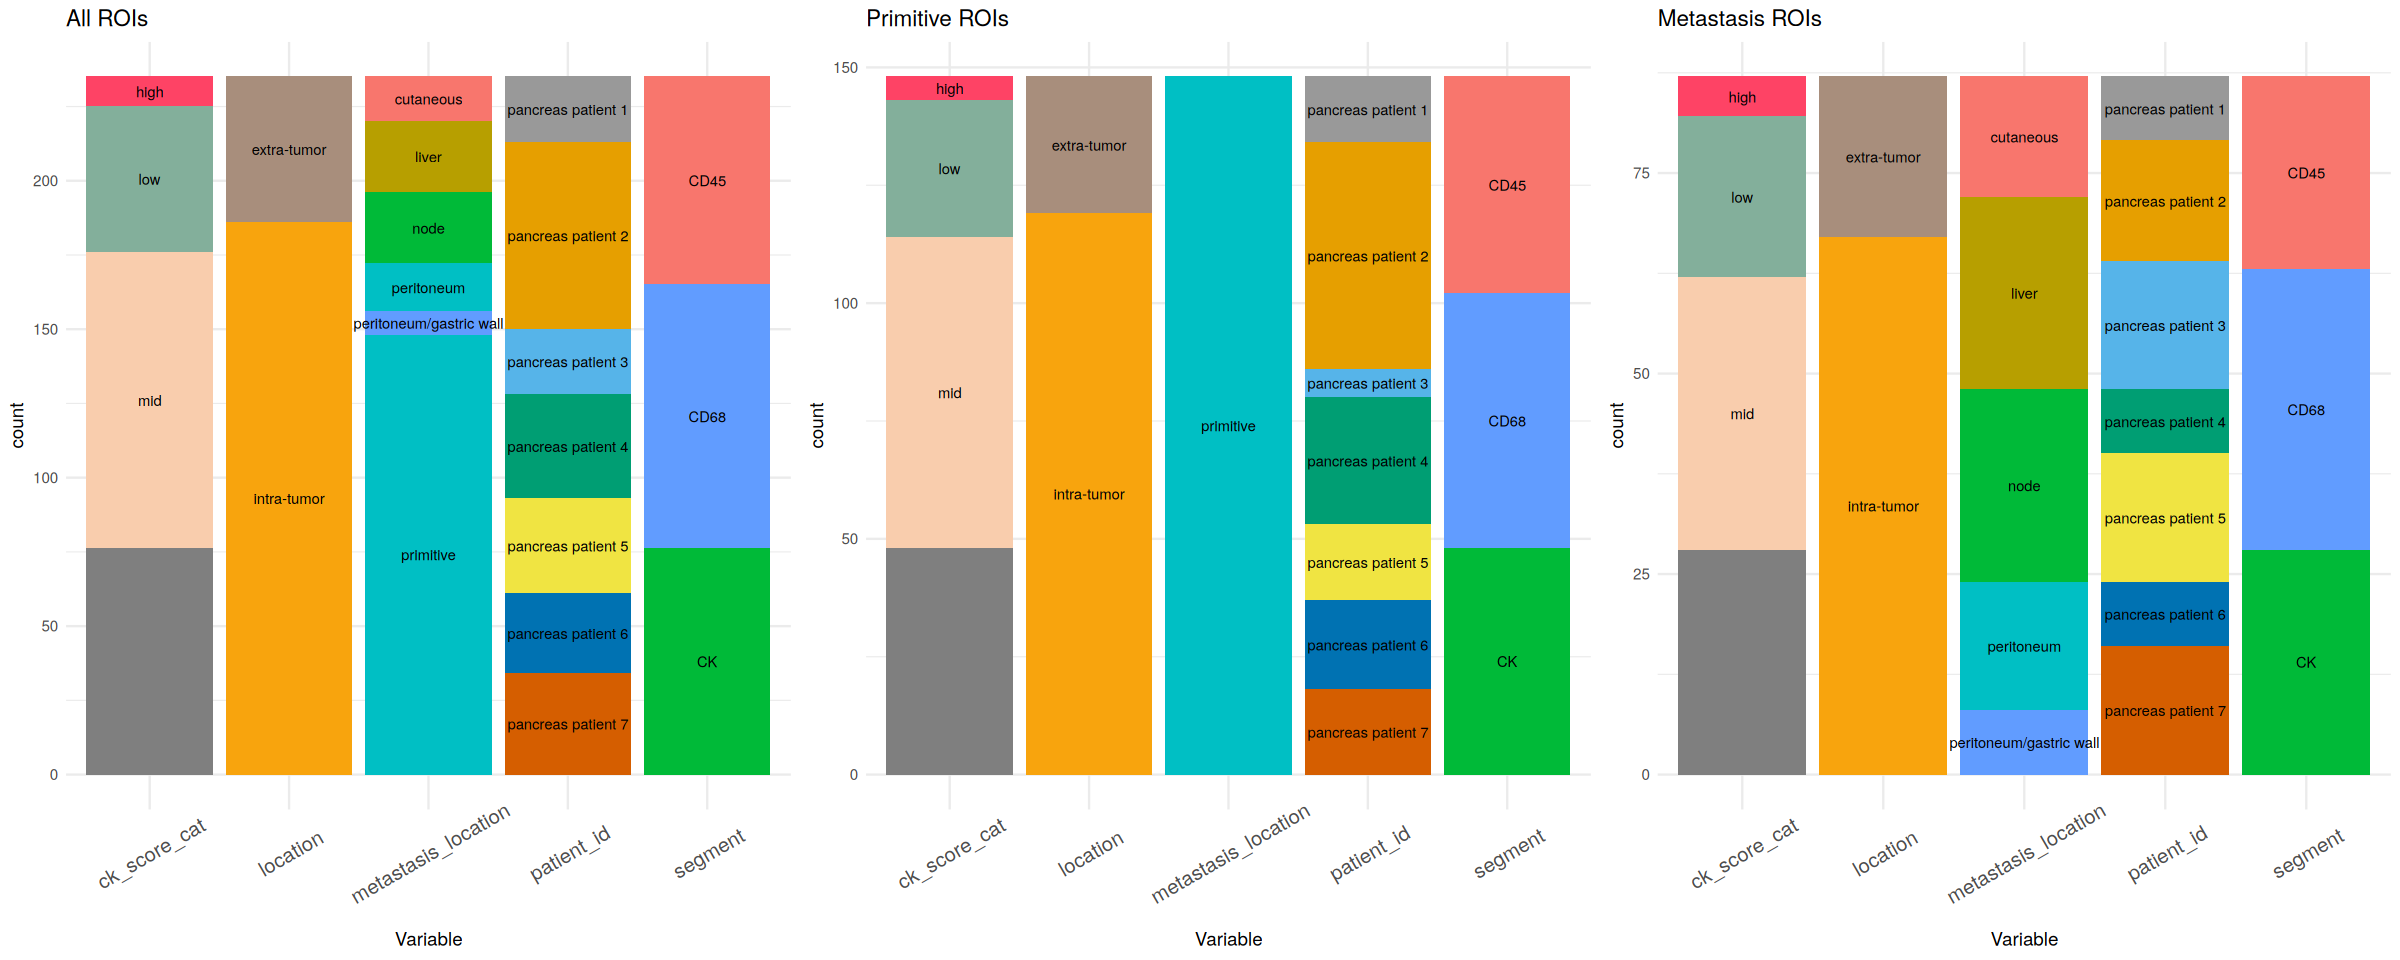

In [30]:
p1 <- stacked_barplot(target_demoData,c('segment','location','metastasis_location','patient_id','ck_score_cat'))  + ggtitle('All ROIs')
p2 <- stacked_barplot(prim_subset,c('segment','location','metastasis_location','patient_id','ck_score_cat')) + ggtitle('Primitive ROIs')
p3 <- stacked_barplot(meta_subset,c('segment','location','metastasis_location','patient_id','ck_score_cat'))  + ggtitle('Metastasis ROIs')

options(repr.plot.width=20, repr.plot.height=8)
grid.arrange(grobs = list(p1,p2,p3), ncol = 3)
options(repr.plot.width=NULL, repr.plot.height=NULL)

# Sankey Plots

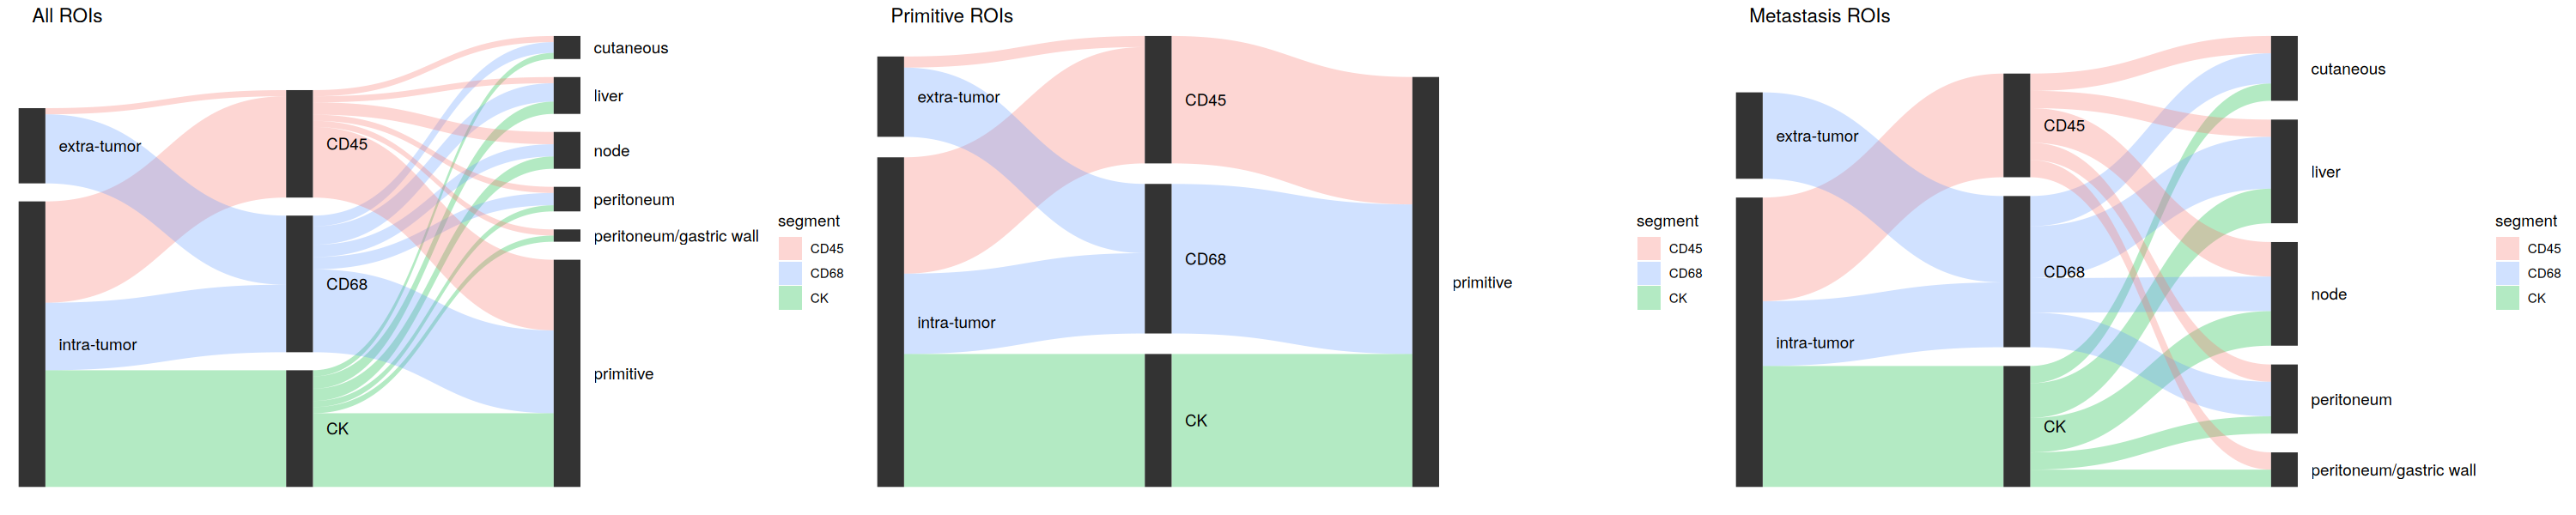

In [32]:
options(repr.plot.width=10, repr.plot.height=7)
p1 <- sankey_plot(pData(target_demoData),c('location','segment','metastasis_location')) + ggtitle("All ROIs")
p2 <- sankey_plot(pData(prim_subset),c('location','segment','metastasis_location'))  + ggtitle("Primitive ROIs")
p3 <- sankey_plot(pData(meta_subset),c('location','segment','metastasis_location')) + ggtitle("Metastasis ROIs")

options(repr.plot.width=25, repr.plot.height=5)
grid.arrange(grobs = list(p1,p2,p3), ncol = 3)
options(repr.plot.width=NULL, repr.plot.height=NULL)

# All segments

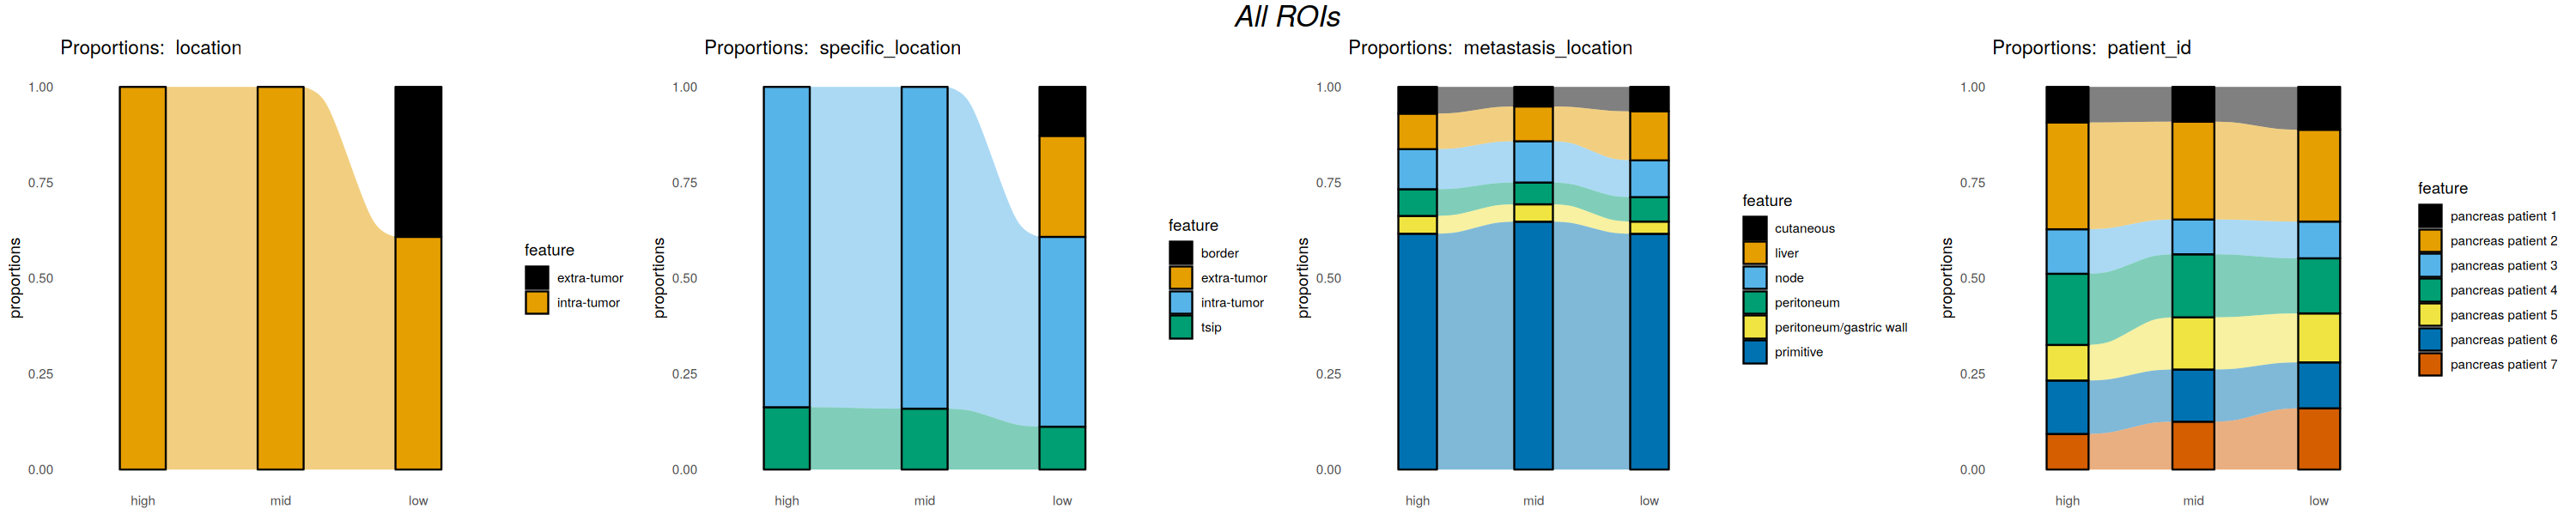

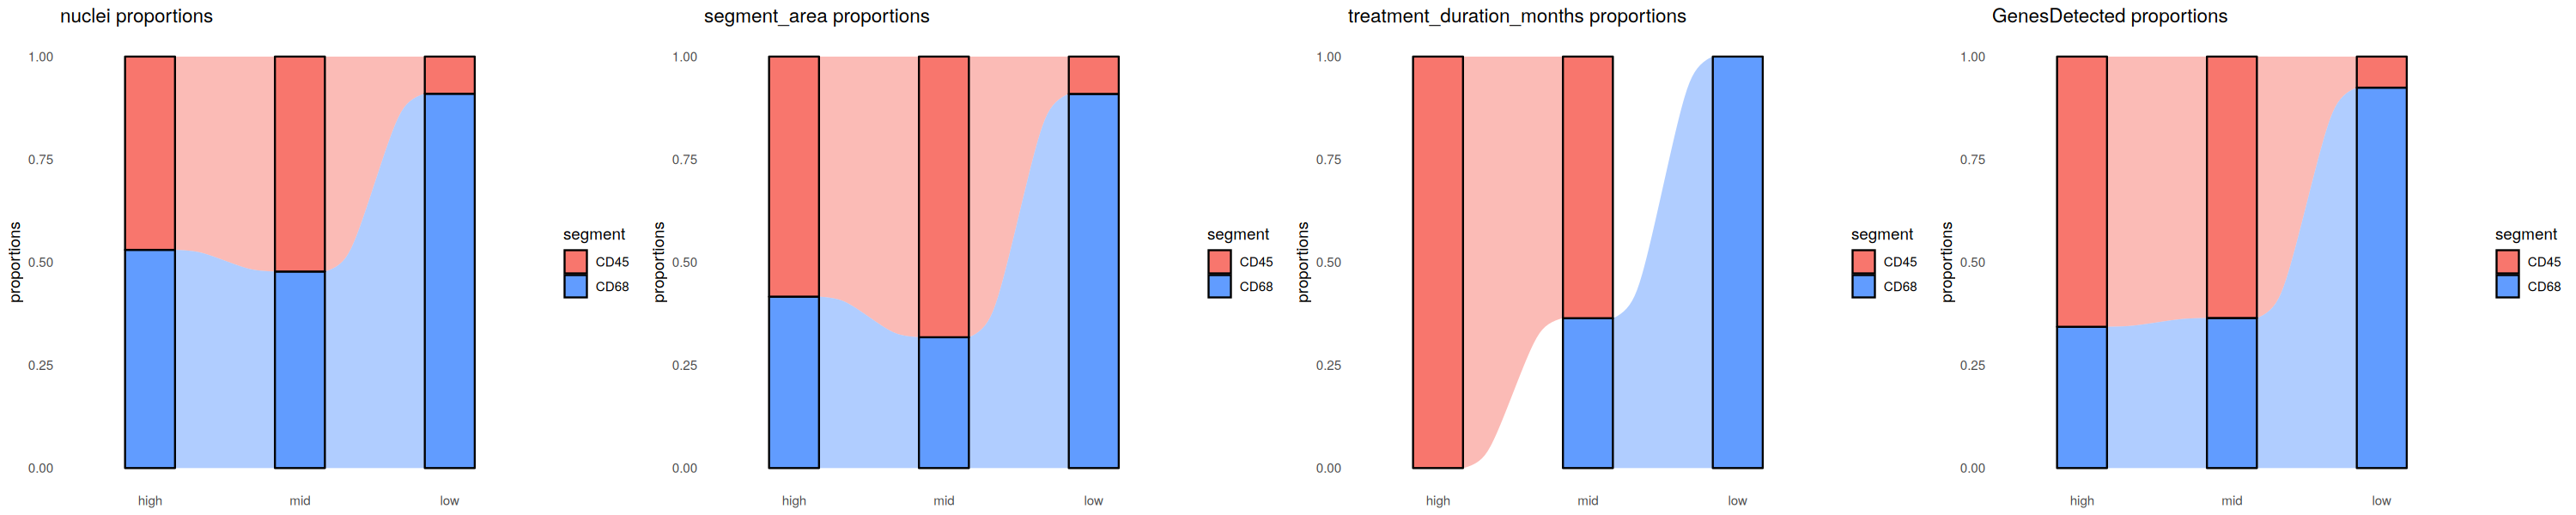

In [61]:
library(zeallot)

plots1 <- list()
plots2 <- list()
c(plots1[[1]], plots2[[1]]) %<-% plot_proportions_categorical(annotations,'location','ck_score_cat')
c(plots1[[2]], plots2[[2]]) %<-% plot_proportions_categorical(annotations,'specific_location','ck_score_cat')
c(plots1[[3]], plots2[[3]]) %<-% plot_proportions_categorical(annotations,'metastasis_location','ck_score_cat')
c(plots1[[4]], plots2[[4]]) %<-% plot_proportions_categorical(annotations,'patient_id','ck_score_cat')
options(repr.plot.width=25, repr.plot.height=5)
grid.arrange(grobs = plots2, ncol = 4,top = textGrob("All ROIs",gp=gpar(fontsize=20,font=3)))
options(repr.plot.width=NULL, repr.plot.height=NULL)

plots1 <- list()
plots2 <- list()
c(plots1[[1]], plots2[[1]]) %<-% plot_proportions(pData(target_demoData),'nuclei','ck_score_cat')
c(plots1[[2]], plots2[[2]]) %<-% plot_proportions(pData(target_demoData),'segment_area','ck_score_cat')
c(plots1[[3]], plots2[[3]]) %<-% plot_proportions(pData(target_demoData),'treatment_duration_months','ck_score_cat')
c(plots1[[4]], plots2[[4]]) %<-% plot_proportions(pData(target_demoData),'GenesDetected','ck_score_cat')

options(repr.plot.width=25, repr.plot.height=5)
grid.arrange(grobs = plots2, ncol = 4)
options(repr.plot.width=NULL, repr.plot.height=NULL)

# primitive segments

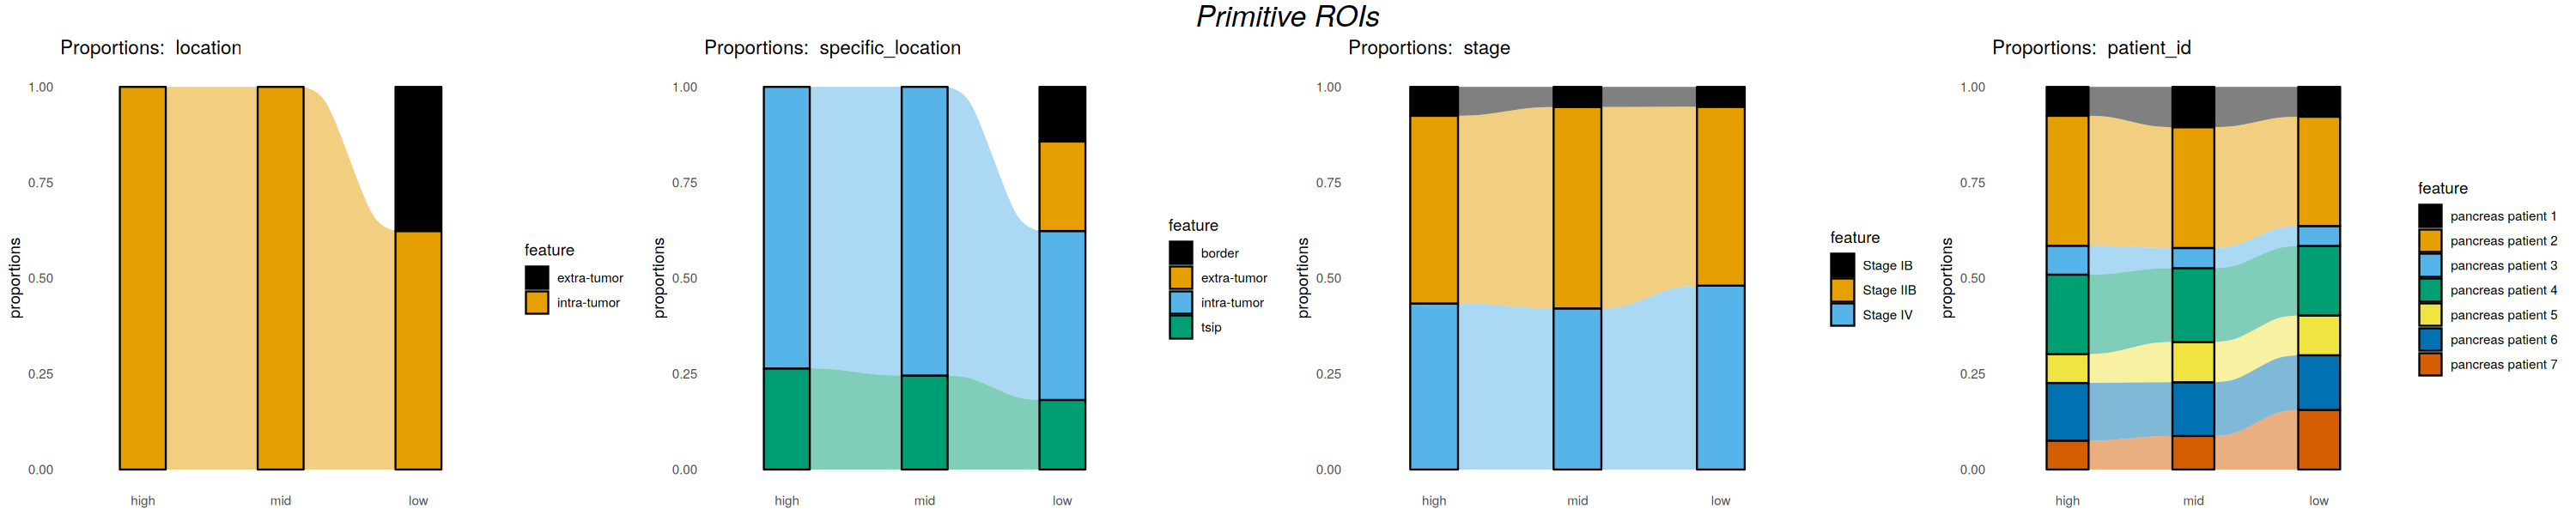

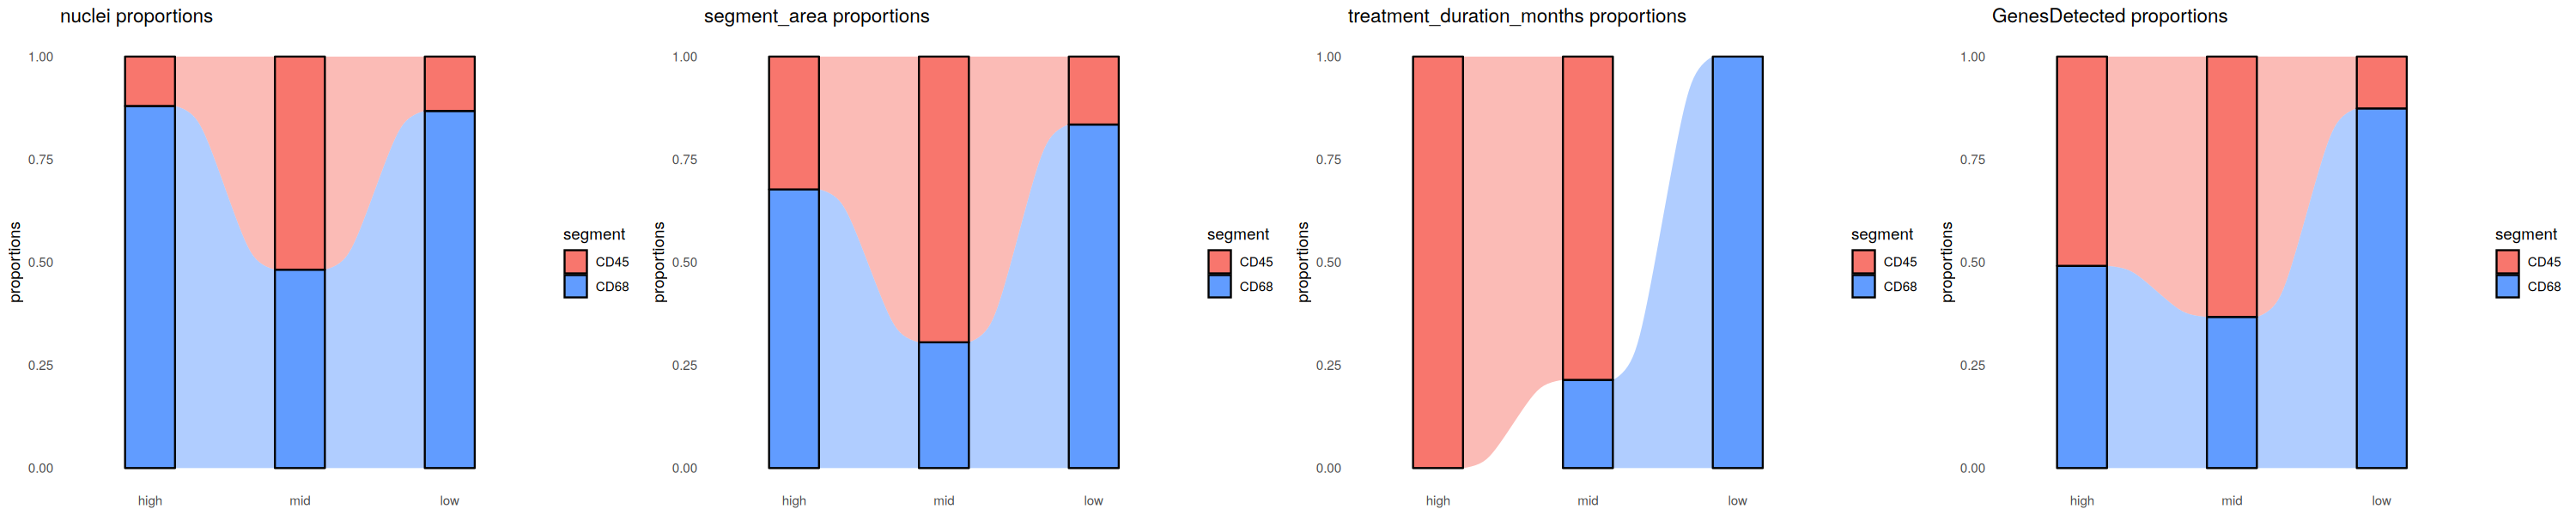

In [60]:
plots1 <- list()
plots2 <- list()
c(plots1[[1]], plots2[[1]]) %<-% plot_proportions_categorical(pData(prim_subset),'location','ck_score_cat')
c(plots1[[2]], plots2[[2]]) %<-% plot_proportions_categorical(pData(prim_subset),'specific_location','ck_score_cat')
c(plots1[[3]], plots2[[3]]) %<-% plot_proportions_categorical(pData(prim_subset),'stage','ck_score_cat')
c(plots1[[3]], plots2[[4]]) %<-% plot_proportions_categorical(pData(prim_subset),'patient_id','ck_score_cat')
options(repr.plot.width=25, repr.plot.height=5)
grid.arrange(grobs = plots2, ncol = 4,top = textGrob("Primitive ROIs",gp=gpar(fontsize=20,font=3)))
options(repr.plot.width=NULL, repr.plot.height=NULL)

plots1 <- list()
plots2 <- list()
c(plots1[[1]], plots2[[1]]) %<-% plot_proportions(pData(prim_subset),'nuclei','ck_score_cat')
c(plots1[[2]], plots2[[2]]) %<-% plot_proportions(pData(prim_subset),'segment_area','ck_score_cat')
c(plots1[[3]], plots2[[3]]) %<-% plot_proportions(pData(prim_subset),'treatment_duration_months','ck_score_cat')
c(plots1[[4]], plots2[[4]]) %<-% plot_proportions(pData(prim_subset),'GenesDetected','ck_score_cat')

options(repr.plot.width=25, repr.plot.height=5)
grid.arrange(grobs = plots2, ncol = 4)
options(repr.plot.width=NULL, repr.plot.height=NULL)

# metastasis segments|

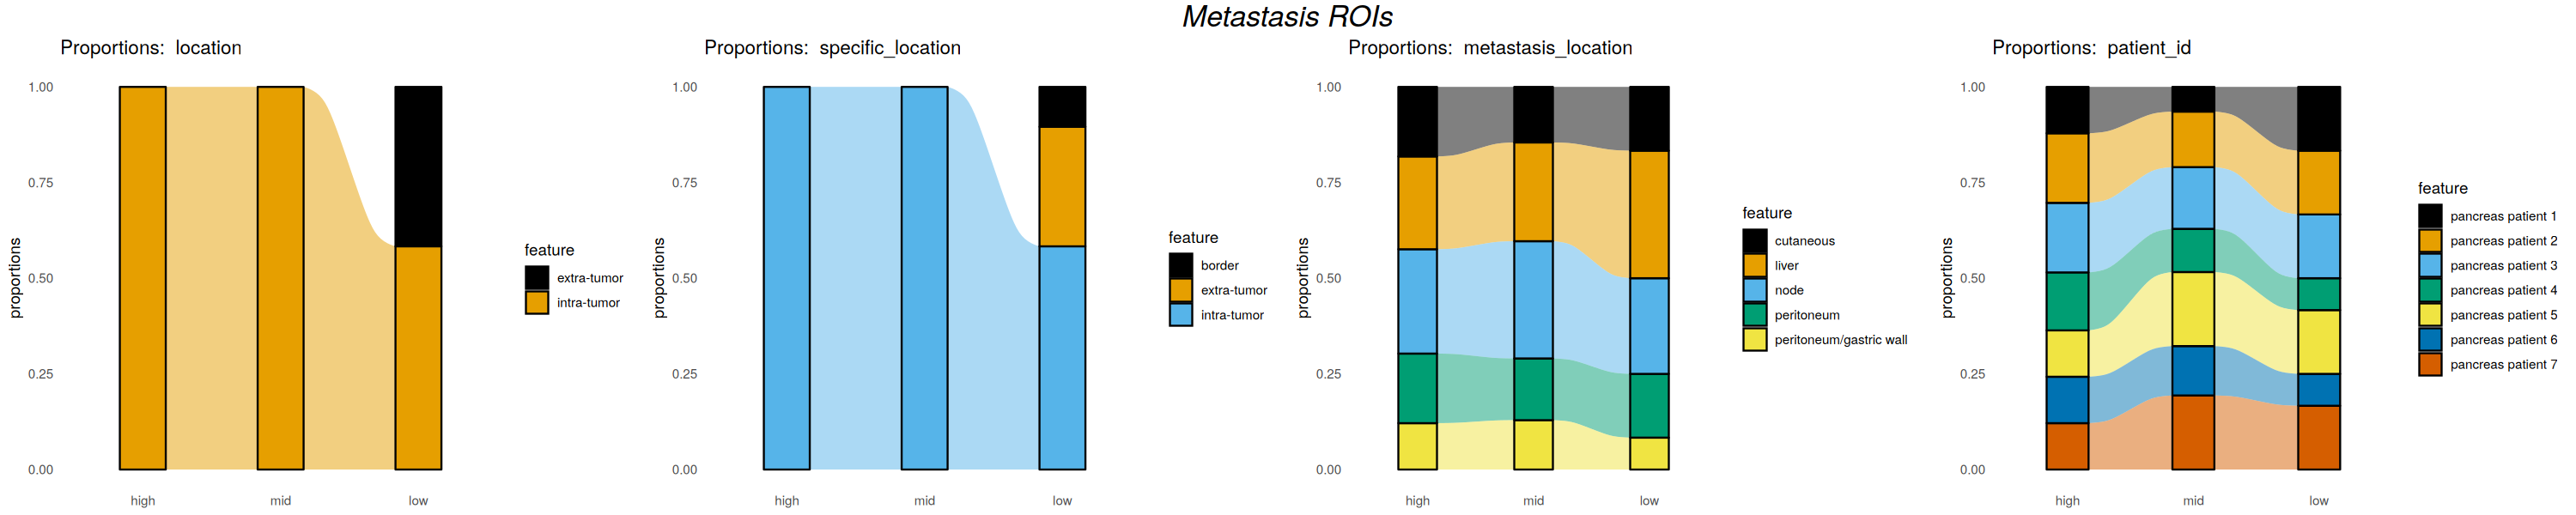

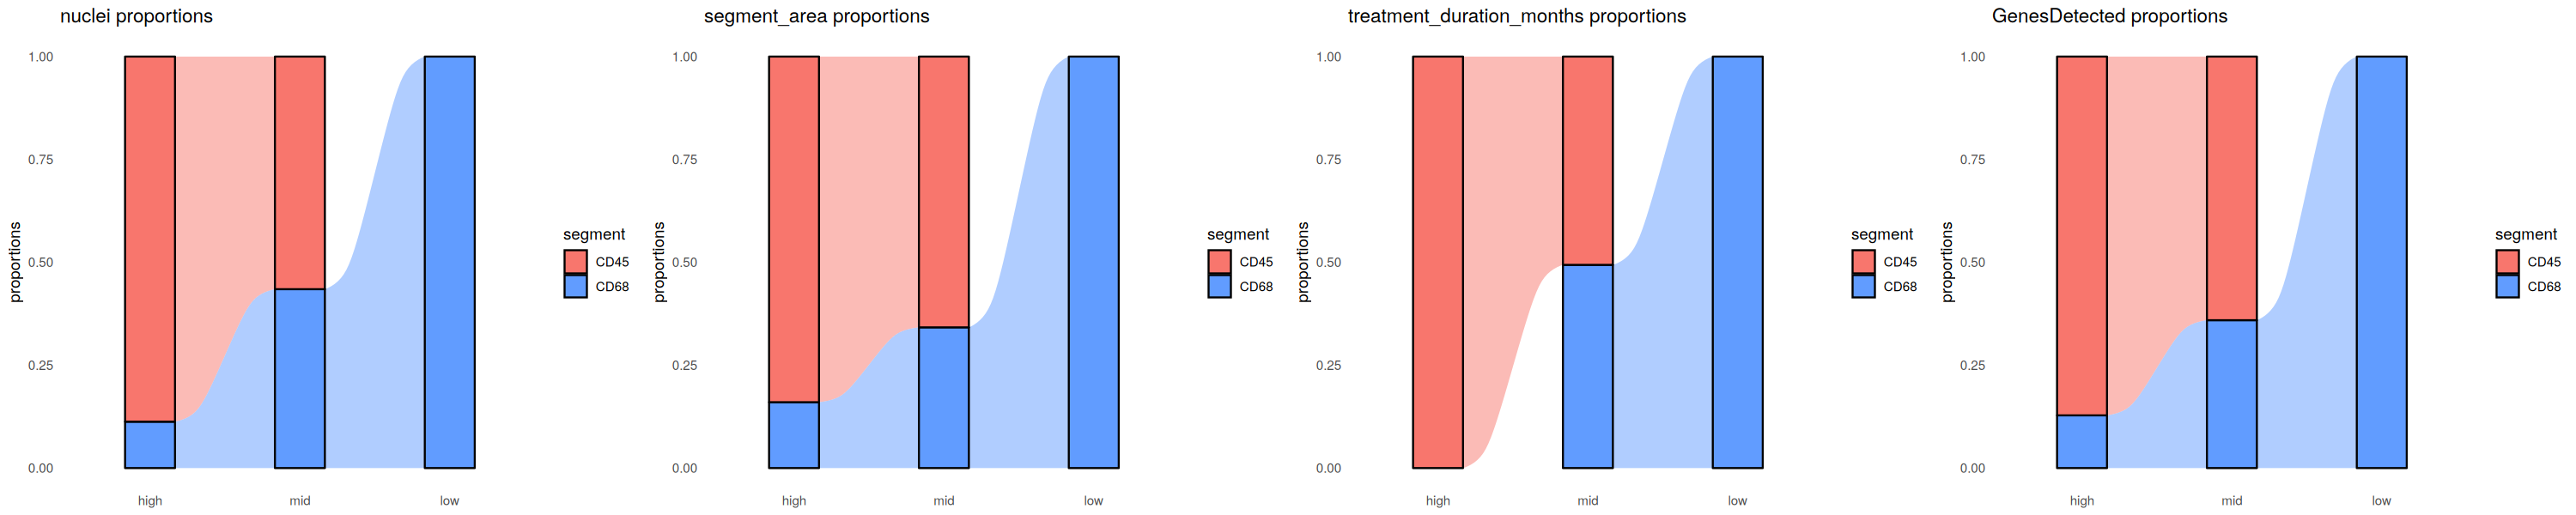

In [63]:
plots1 <- list()
plots2 <- list()
library(grid)
c(plots1[[1]], plots2[[1]]) %<-% plot_proportions_categorical(pData(meta_subset),'location','ck_score_cat')
c(plots1[[2]], plots2[[2]]) %<-% plot_proportions_categorical(pData(meta_subset),'specific_location','ck_score_cat')
c(plots1[[3]], plots2[[3]]) %<-% plot_proportions_categorical(pData(meta_subset),'metastasis_location','ck_score_cat')
c(plots1[[3]], plots2[[4]]) %<-% plot_proportions_categorical(pData(meta_subset),'patient_id','ck_score_cat')
options(repr.plot.width=25, repr.plot.height=5)
grid.arrange(grobs = plots2, ncol = 4,top = textGrob("Metastasis ROIs",gp=gpar(fontsize=20,font=3)))
options(repr.plot.width=NULL, repr.plot.height=NULL)

plots1 <- list()
plots2 <- list()
c(plots1[[1]], plots2[[1]]) %<-% plot_proportions(pData(meta_subset),'nuclei','ck_score_cat')
c(plots1[[2]], plots2[[2]]) %<-% plot_proportions(pData(meta_subset),'segment_area','ck_score_cat')
c(plots1[[3]], plots2[[3]]) %<-% plot_proportions(pData(meta_subset),'treatment_duration_months','ck_score_cat')
c(plots1[[4]], plots2[[4]]) %<-% plot_proportions(pData(meta_subset),'GenesDetected','ck_score_cat')

options(repr.plot.width=25, repr.plot.height=5)
#grid.arrange(grobs = plots1, ncol = 7)
grid.arrange(grobs = plots2, ncol = 4)
options(repr.plot.width=NULL, repr.plot.height=NULL)

# UMAPs

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’



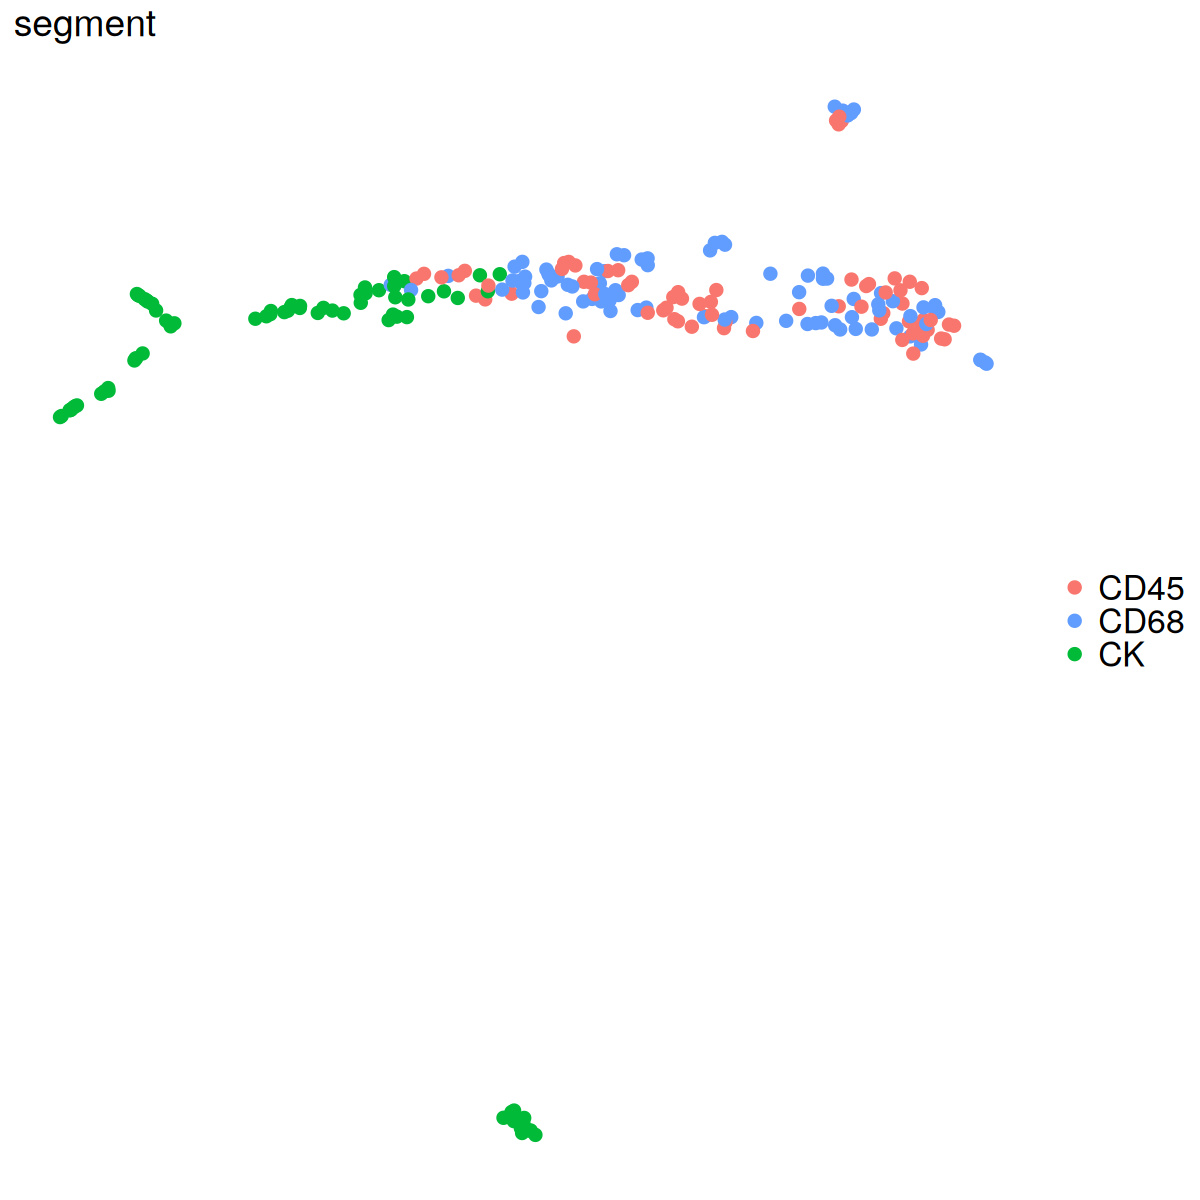

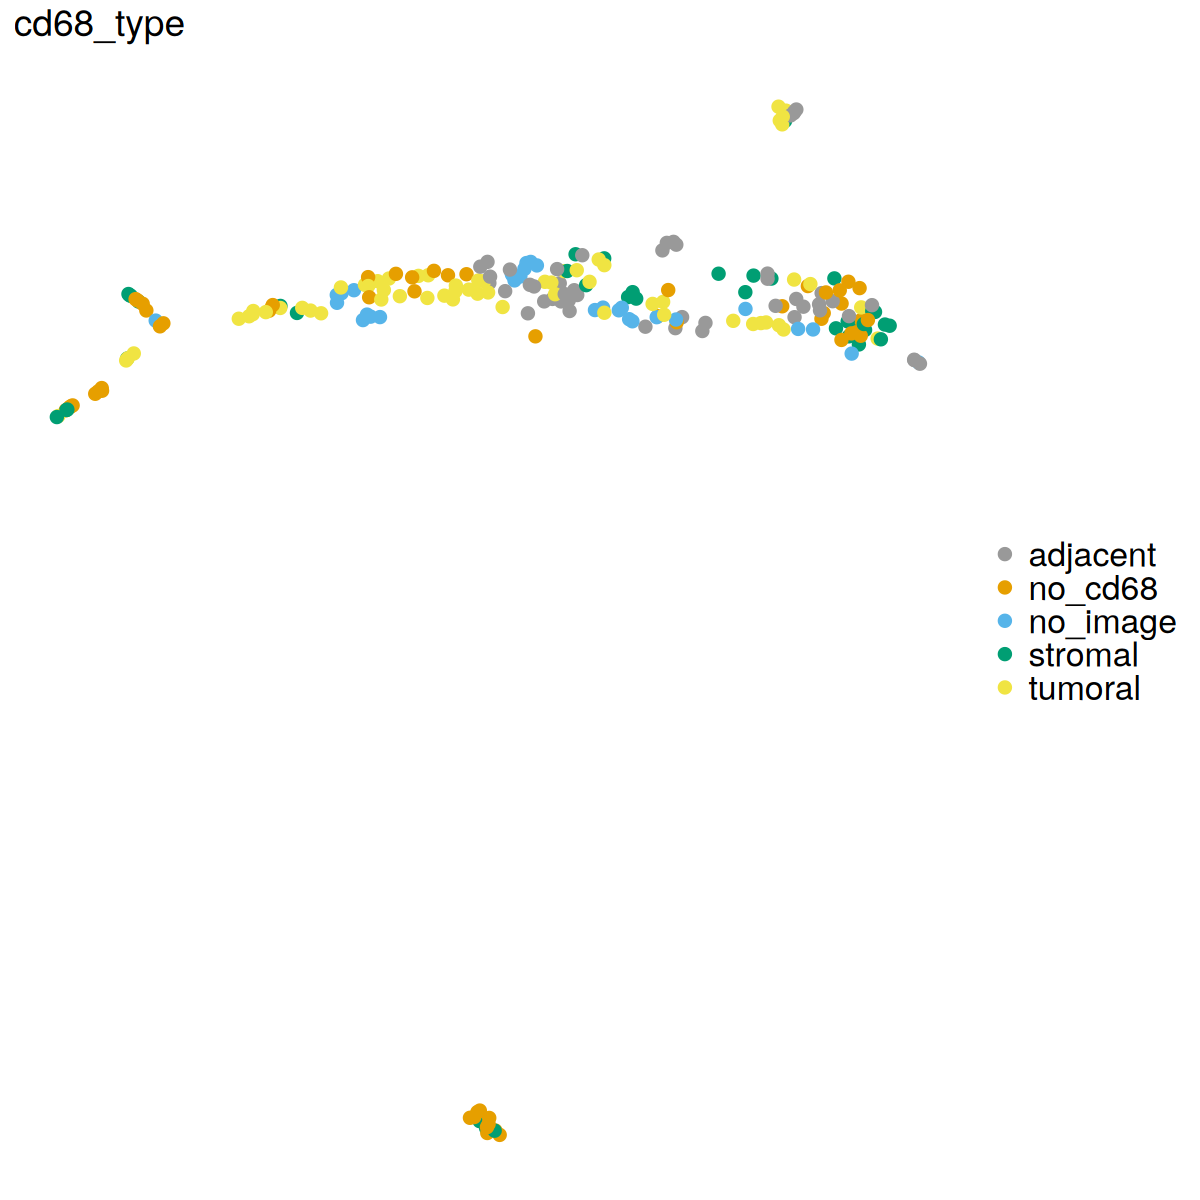

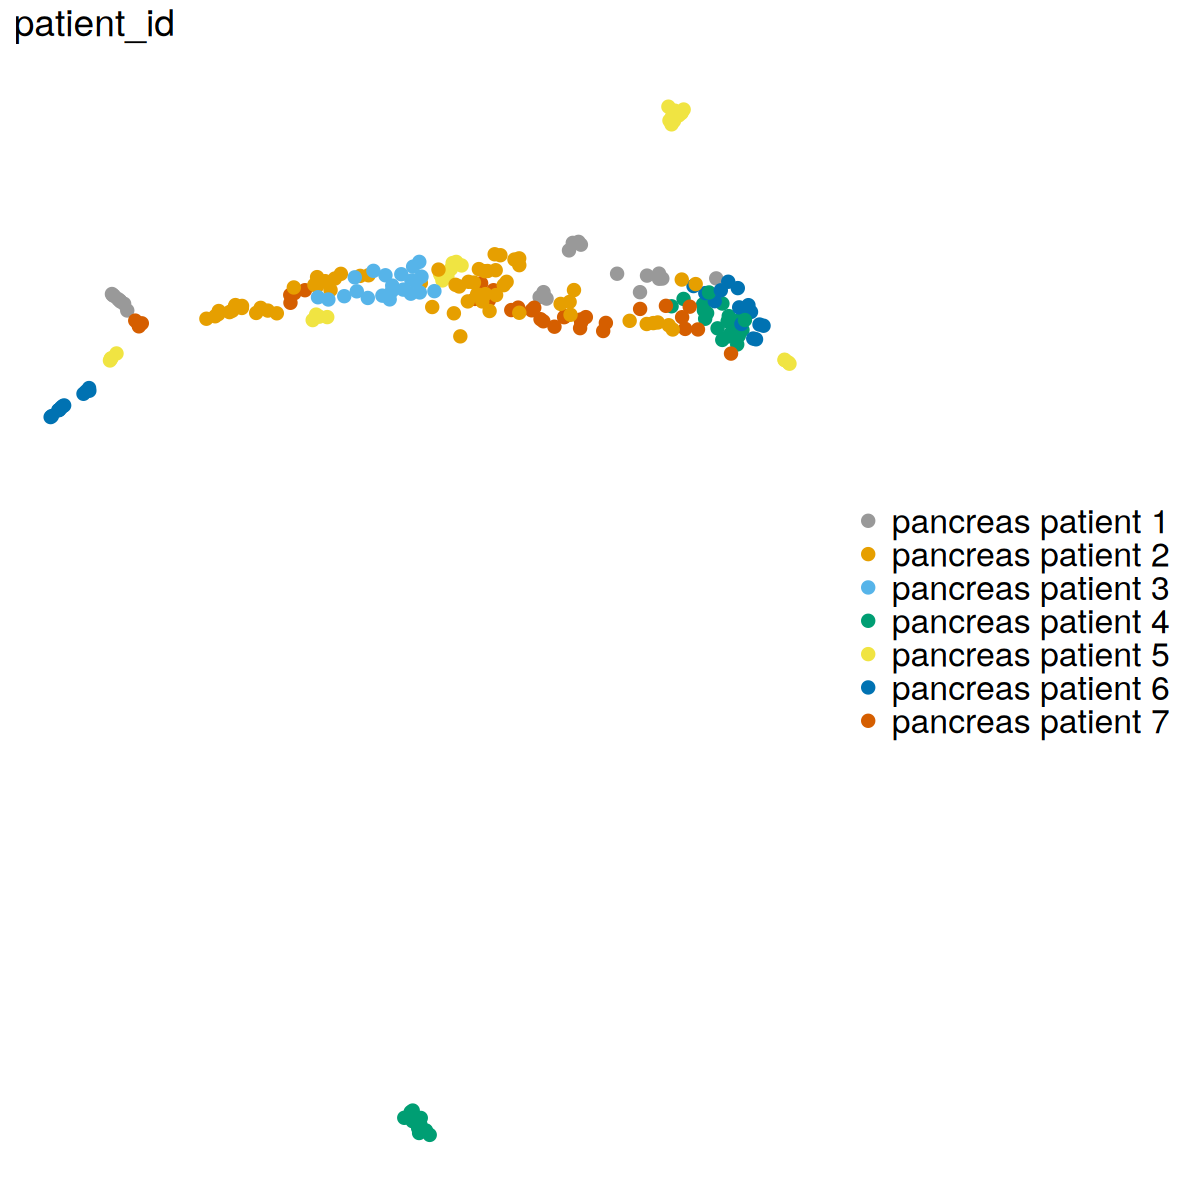

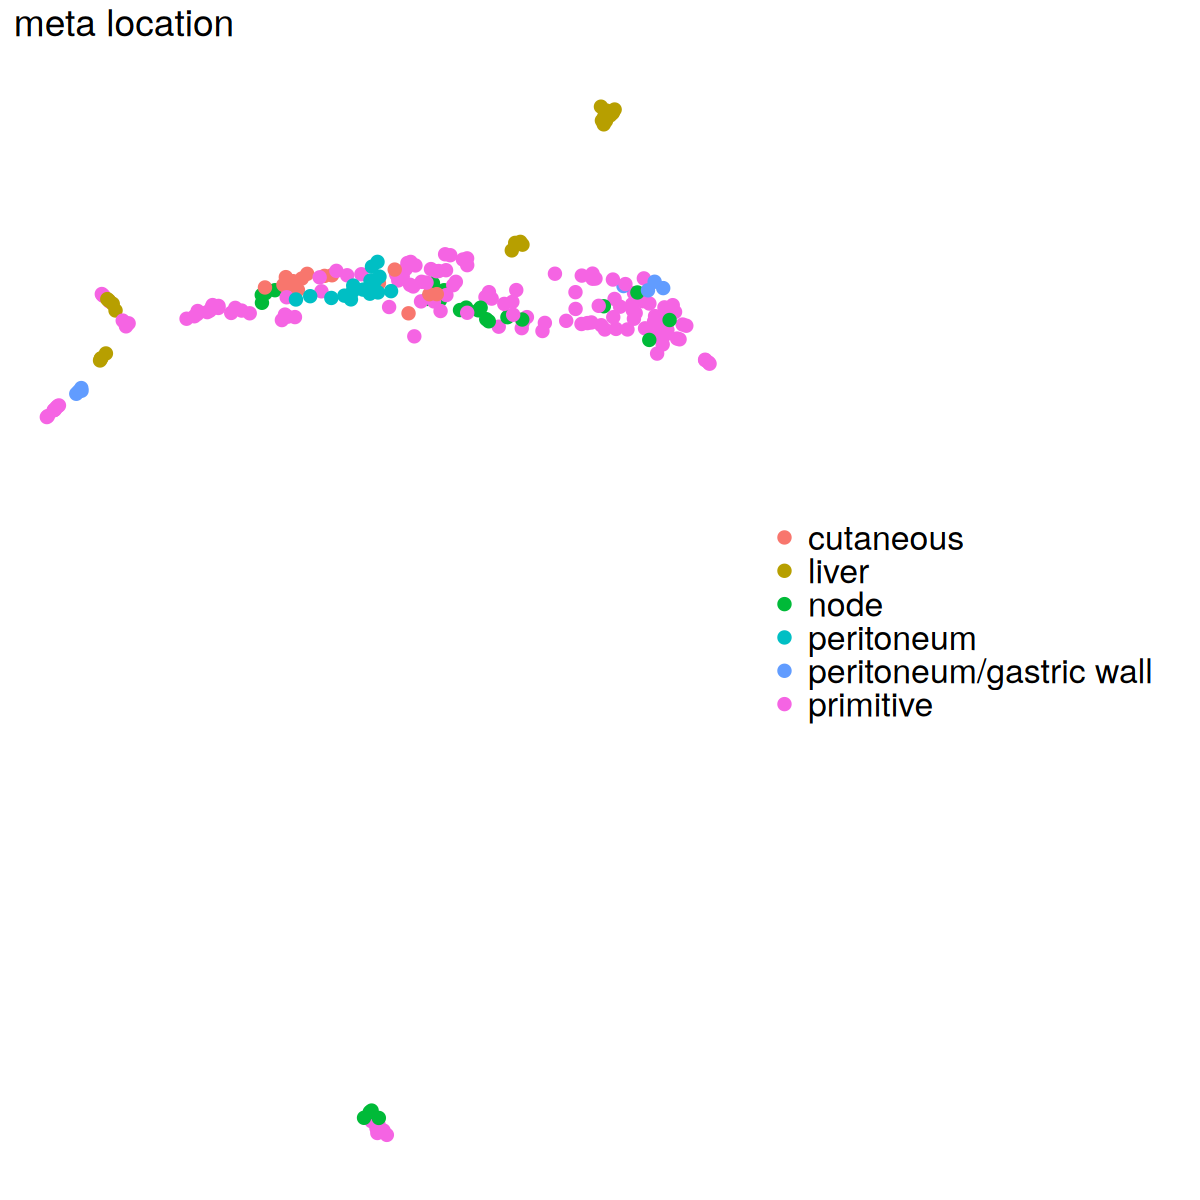

Warning message:
“Removed 76 rows containing missing values or values outside the scale range (`geom_point()`).”


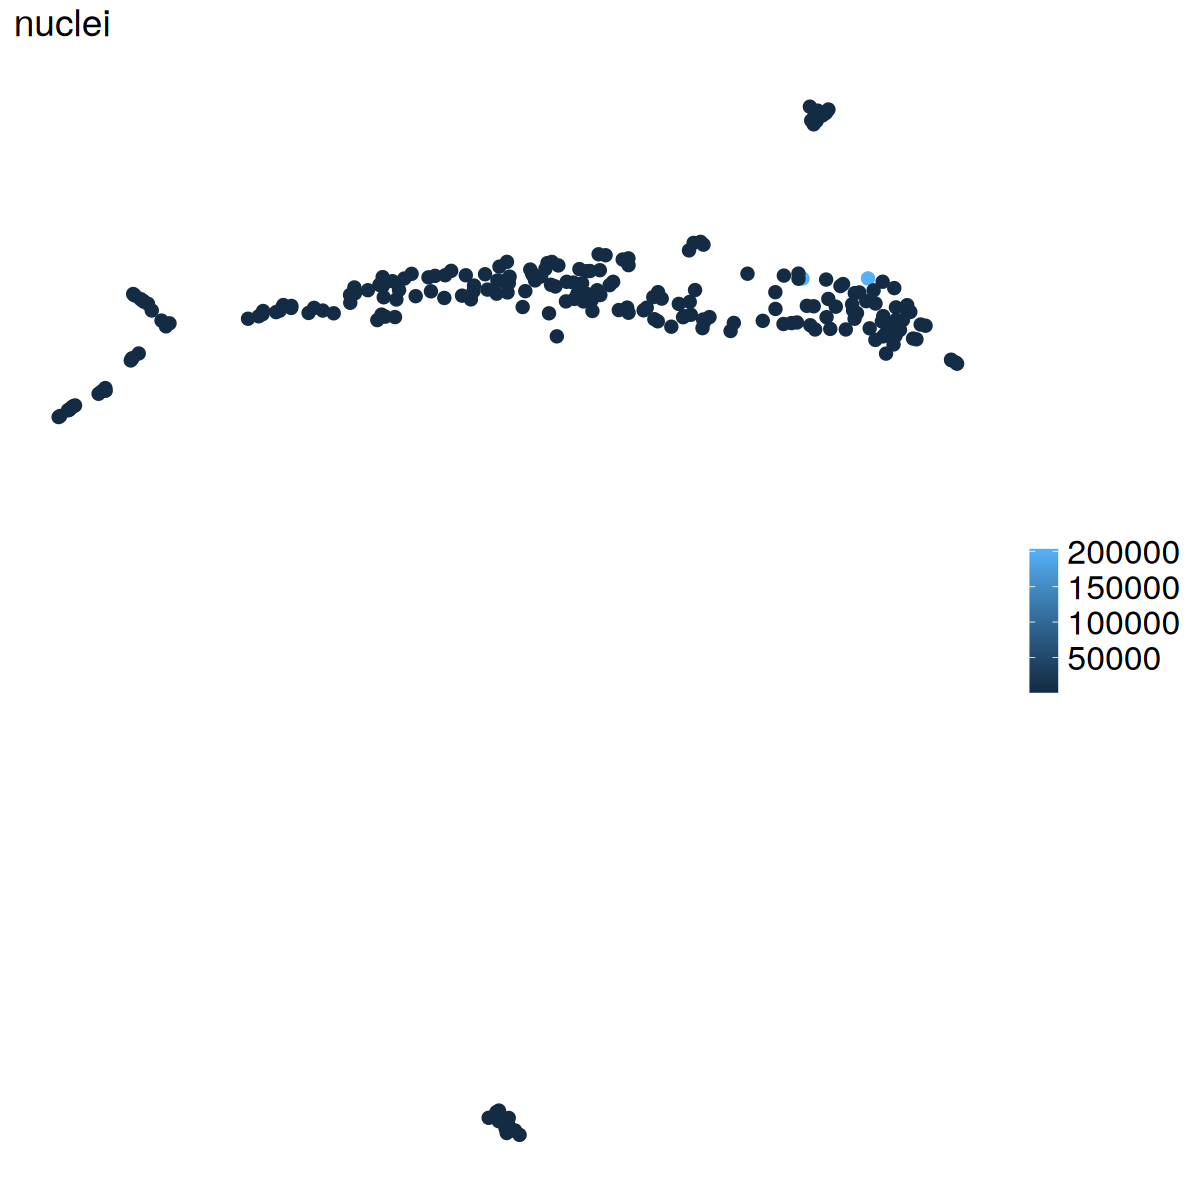

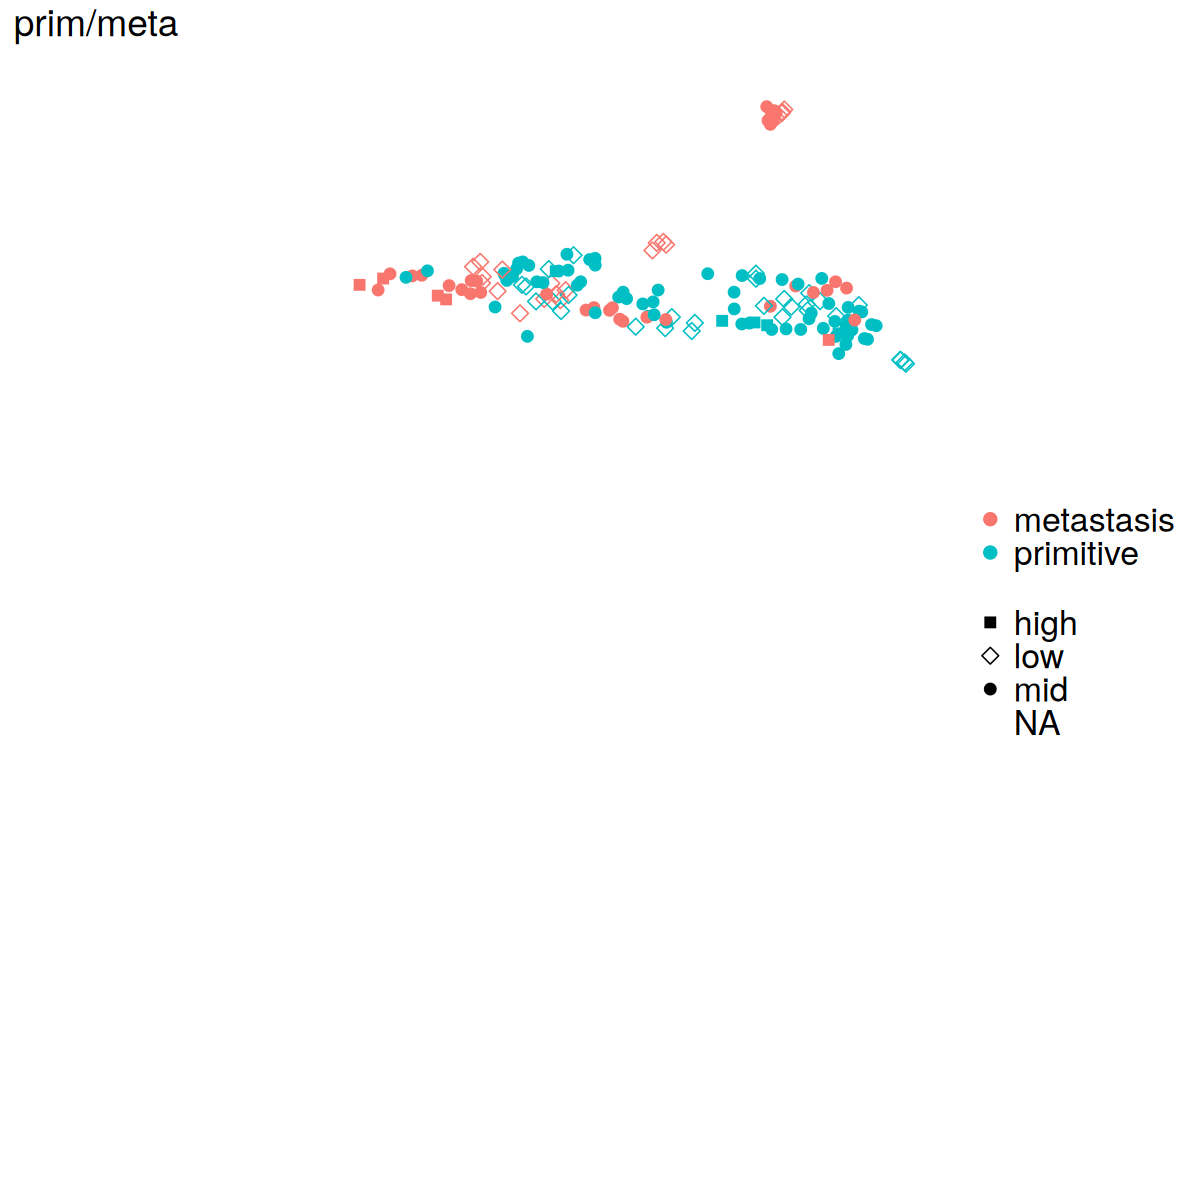

In [72]:
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
segment_palette <- c(cd45_color,cd68_color,ck_color)
target_demoData <- run_umap(target_demoData)
options(repr.plot.width=10, repr.plot.height=10)

umap_plot(target_demoData,"segment","segment",colors = segment_palette)
umap_plot(target_demoData,"cd68_type","cd68_type",colors = cbPalette)
umap_plot(target_demoData,"patient_id","patient_id",colors = cbPalette)
umap_plot(target_demoData,"meta location","metastasis_location")
umap_plot(target_demoData,"nuclei","nuclei")
umap_plot(target_demoData,"prim/meta","primitive_metastasis",label2 = 'ck_score_cat')

Warning message:
“Removed 76 rows containing missing values or values outside the scale range (`geom_point()`).”


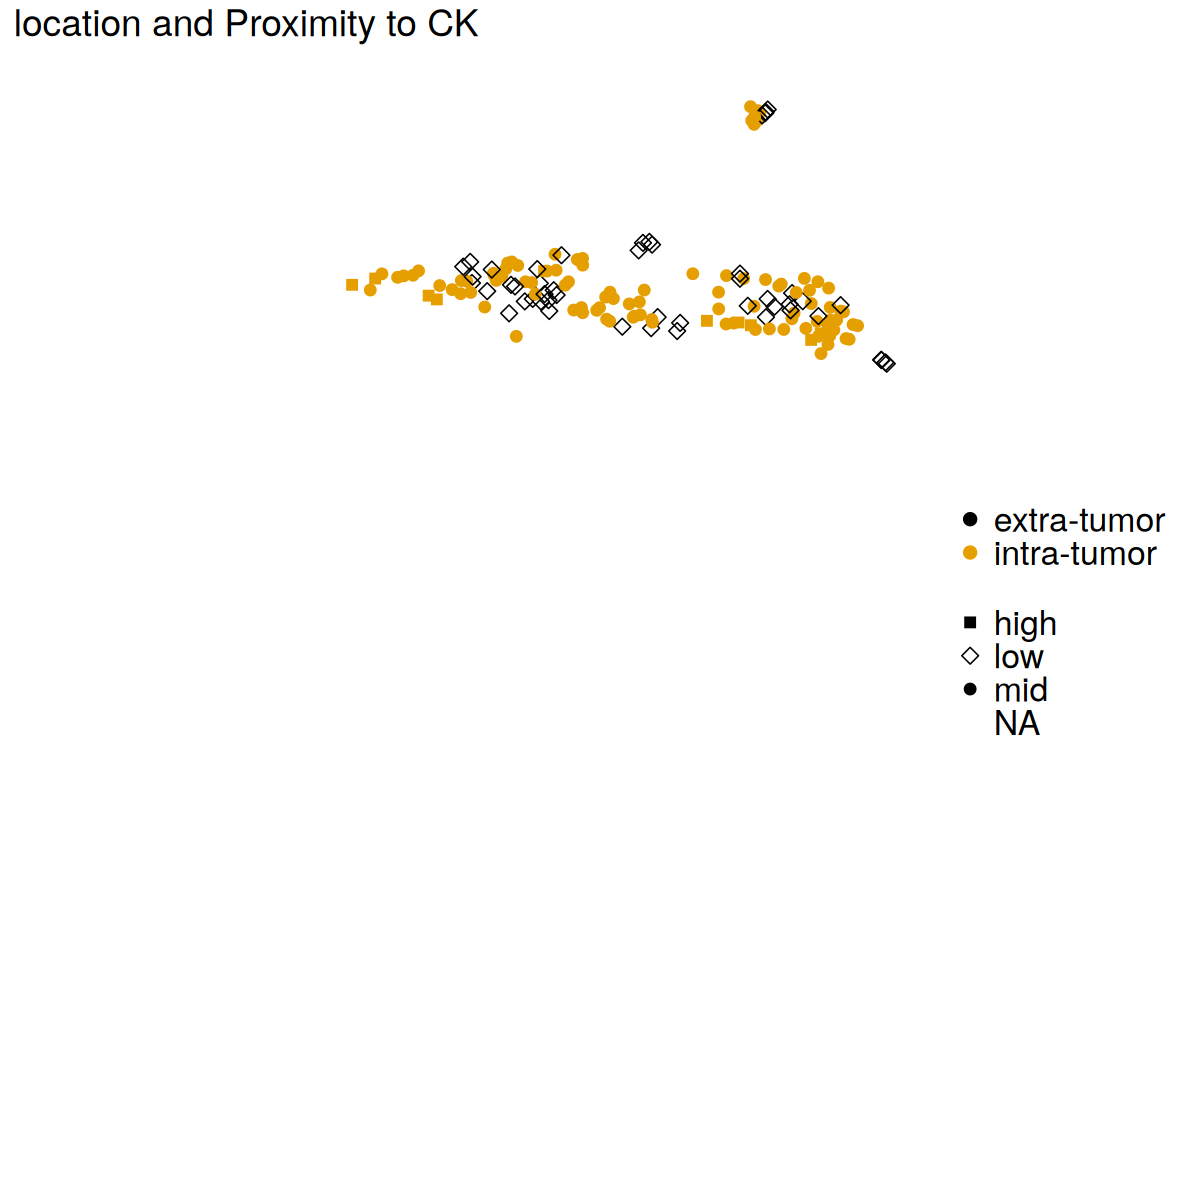

In [75]:
umap_plot(target_demoData,"location and Proximity to CK","location",colors = cbbPalette,label2 = 'ck_score_cat')
